In [ ]:
# validate google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# assign folder
FOLDERNAME = 'Colab\ Notebooks/SC201_project'
%cd drive/MyDrive/$FOLDERNAME


Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/SC201_project


In [ ]:
%ls

adversarial_example_generator.ipynb  data/  Reference/


In [ ]:
# launch GPU
import torch
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as T
from torchvision import models

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# load model
def load_model() -> nn.Module:
  model = models.inception_v3(pretrained=True)
  model.eval()
  return model

In [ ]:
# data preprocessing
def process(img):
  """
  Inception V3 model from pytorch expects input images with pixel values between -1 and 1
  and dimensions 299 x 299
  """
  # parameter for normalization
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]
  transform = T.Compose([
      T.Resize((299, 299)),
      T.ToTensor(),
      T.Normalize(mean, std)
  ])

  image_T = transform(img)

  # add batch dimension: C X H X W --> B X C X H X W (B = 1) [for successfully train]
  image_T = image_T.unsqueeze(dim=0)

  return image_T

In [ ]:
# get prediction
from torch import Tensor
from easydict import EasyDict
import torch.nn.functional as F
from data.id2label import id2label

def predict(model: nn.Module, img: Tensor):
  score = model(img)
  prediction = score.max(1)[1].item()
  label = id2label[prediction]
  probability = F.softmax(score, dim=1)
  confidence = round(probability.max(1)[0].item(), 4)

  return EasyDict(
      id=prediction,
      label=label,
      confidence=confidence
  )


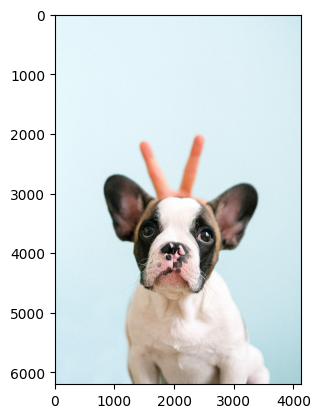

In [ ]:
# load clean data and get its prediction

TRAIN_PATH = './data/dog_clean.jpg'
img = Image.open(TRAIN_PATH)
plt.imshow(img)

In [ ]:
x = process(img)

In [ ]:
model = load_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 100MB/s] 


In [ ]:
predict(model, x)

{'id': 245, 'label': 'French bulldog', 'confidence': 0.8927}

In [ ]:
# for visualization
# def visualize(x, x_adv, x_grad, epsilon):
#     """
#     :param x: clean data, tensor
#     :param x_adv: adversarial example, tensor
#     :param x_grad:
#     :param epsilon: int,
#     :return: plt
#     """
#     # get predicted label and confidence of x
#     x_predictions = predict(model, x)
#     x_label = x_predictions.label
#     x_prob = x_predictions.confidence

#     # get predicted label and confidence of x_adv
#     x_adv_predictions = predict(model, x_adv)
#     x_adv_label = x_adv_predictions.label
#     x_adv_prob = x_adv_predictions.confidence

#     # transform x into its raw form for visualization
#     x = x.squeeze(0) # remove batch dimension: B x C x H x W ==> C x H x W
#     x = inverse_preprocess(x)
#     x = np.transpose( x , (1,2,0)) # C x H x W ==> H x W x C
#     x = np.clip(x, 0, 1)

#     # transform x_adv into its raw form for visualization
#     x_adv = x_adv.squeeze(0)
#     x_adv = inverse_preprocess(x_adv)
#     x_adv = np.transpose( x_adv , (1,2,0))   # C X H X W  ==>   H X W X C
#     x_adv = np.clip(x_adv, 0, 1)

#     # transform grad into its raw form for visualization
#     x_grad = x_grad.squeeze(0).numpy()
#     x_grad = np.transpose(x_grad, (1,2,0))
#     x_grad = np.clip(x_grad, 0, 1)

#     # ----------------
#     # start plotting
#     # ----------------
#     figure, ax = plt.subplots(1,3, figsize=(18,8))
#     ax[0].imshow(x)
#     ax[0].set_title('Clean Example', fontsize=20)

#     ax[1].imshow(x_grad)
#     ax[1].set_title('Perturbation', fontsize=20)
#     ax[1].set_yticklabels([])
#     ax[1].set_xticklabels([])
#     ax[1].set_xticks([])
#     ax[1].set_yticks([])


#     ax[2].imshow(x_adv)
#     ax[2].set_title('Adversarial Example', fontsize=20)

#     ax[0].axis('off')
#     ax[2].axis('off')

#     ax[0].text(1.1,0.5, "+{}*".format(round(epsilon,3)), size=15, ha="center",
#                transform=ax[0].transAxes)

#     ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(x_label, x_prob), size=15, ha="center",
#                transform=ax[0].transAxes)

#     ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

#     ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(x_adv_label, x_adv_prob), size=15, ha="center",
#                transform=ax[2].transAxes)


#     plt.show()


def inverse_preprocess(x):
    t = x.squeeze(0)

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    t = t.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)) #.numpy()

    im = T.ToPILImage()(t) #.convert("RGB") #.Resize((299, 299))

    return im

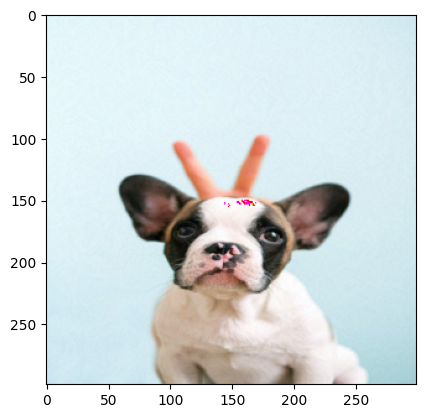

In [ ]:
# generate adversarial example

# Fast Gradient Sign Method (FGSM)
def fgsm(x, eps):
  """
  :param x: Tensor, clean data
  :param eps: float, epilson for generating adversarial example, a hyperparameter
  :return: Tuple, adversarial example of x and x_gradient
  """
  img_v = Variable(x, requires_grad=True)

  # forward pass on the original image
  output = model(img_v)

  # get prediction
  y_true = torch.max(output.data, 1)[1]

  # loss
  loss_fn = torch.nn.CrossEntropyLoss()
  loss = loss_fn(output, y_true)

  # backward prop
  loss.backward(retain_graph=True)

  # sign of gradient of the loss func (with respect to input X)
  x_grad = torch.sign(img_v.grad.data)

  # fast gradient sign formula
  x_adversarial = img_v.data + eps * x_grad

  return x_adversarial, x_grad

epsilon = 0.02
x_adv, grad = fgsm(x, epsilon)
plt.imshow(inverse_preprocess(x_adv))


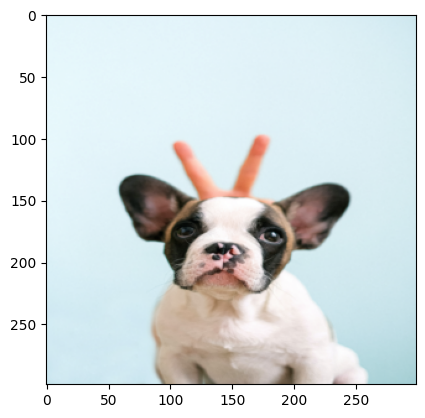

In [ ]:
plt.imshow(inverse_preprocess(x))

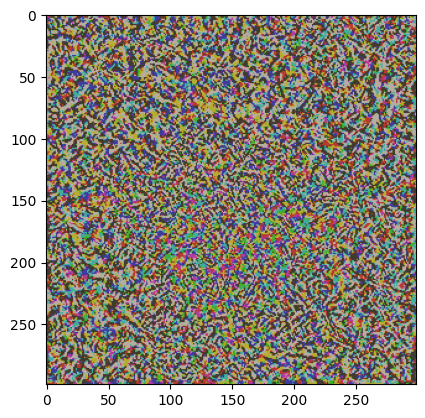

In [ ]:
plt.imshow(inverse_preprocess(grad))

In [ ]:
predict(model, x_adv)

{'id': 195, 'label': 'Boston bull', 'confidence': 0.7454}

In [ ]:
# iterative fgsm
def iterative_fgsm(x_: Tensor, epsilon: float, iter: int, alpha: float):

    # copy to avoid modifying the original tensor
    x = x_.clone().detach()

    for iteration in range(iter):

        # one step using basic FGSM
        x_adv, grad = fgsm(x, alpha)

        # total perturbation
        total_grad = x_adv - x_

        # force total perturbation to be lower than epsilon in
        # absolute value
        total_grad = torch.clamp(total_grad, -epsilon, epsilon)

        # add total perturbation to the original image
        x_adv = x_ + total_grad

        x = x_adv

        if iteration % 10 ==0:
          print(f'run: {iteration+1}')

    return x_adv, total_grad

In [ ]:
epsilon_i = 0.03
iter = 90
alpha = 0.015
x_adv_i, grad_i = iterative_fgsm(x, epsilon_i, iter, alpha)

run: 1
run: 11
run: 21
run: 31
run: 41
run: 51
run: 61
run: 71
run: 81


In [ ]:
predict(model, x_adv_i)

{'id': 514, 'label': 'cowboy boot', 'confidence': 0.0646}

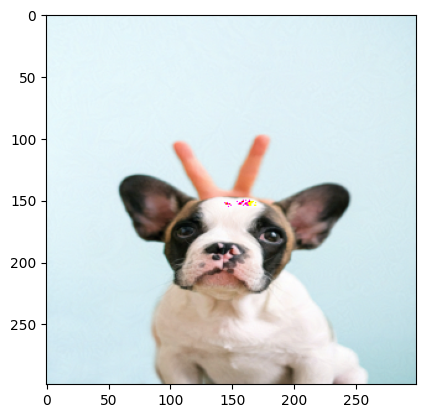

In [ ]:
plt.imshow(inverse_preprocess(x_adv_i))

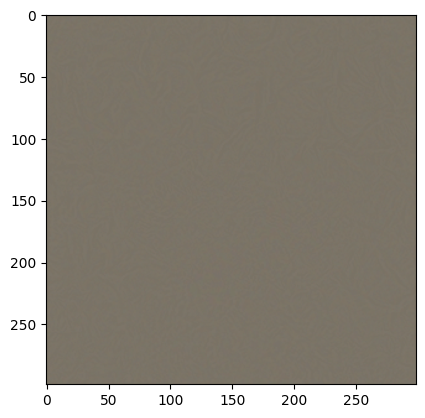

In [ ]:
plt.imshow(inverse_preprocess(grad_i))